In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [ ]:
# re-size all the images to this
train_path = '/content/drive/My Drive/db/train'
valid_path = '/content/drive/My Drive/db/test'

In [ ]:
IMAGE_SIZE = (331, 331,3)
nasNet = NASNetLarge(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
# don't train existing weights
for layer in nasNet.layers:
    layer.trainable = False

# useful for getting number of output classes
folders = glob('/content/drive/My Drive/db/train/*')
x = Flatten()(nasNet.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=nasNet.input, outputs=prediction)
#model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

343613440/343610240 [==============================] - 2s 0us/step


In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/db/train',
                                                 target_size = (331, 331),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2950 images belonging to 3 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/db/test',
                                            target_size = (331, 331),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 690 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'saved_model/'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# fit the model
# Run the cell. It will take some time to execute
nasnet_model = model.fit(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[model_checkpoint_callback]
)

In [ ]:
# save it as a h5 file
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/nasnet.h5')

In [ ]:
from google.colab import files
files.download("saved_model/nasnet.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/db/models/nasnet.h5')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_______________________________________________________________________________________

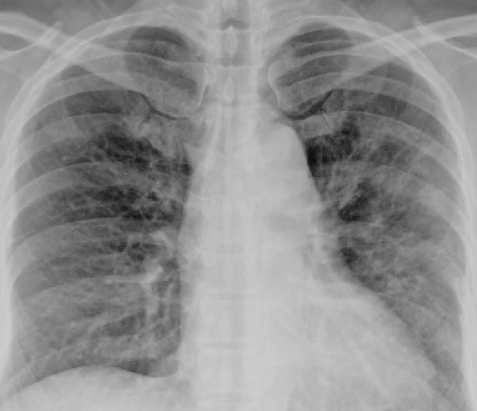

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

img_size = (331, 331)
preprocess_input = keras.applications.nasnet.preprocess_input

last_conv_layer_name = "activation_259"
classifier_layer_names = [
    "flatten",
    "dense",
]

# The local path to our target image
img_path = "/content/drive/MyDrive/db/test/covid/covid68.png"

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

[0]


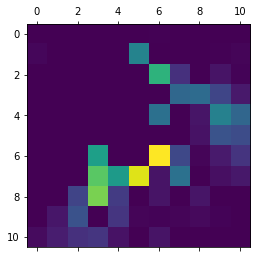

In [ ]:
#Prepare image

img_array = preprocess_input(get_img_array(img_path, size=img_size))
 

# Print what the top predicted class is
preds = model.predict(img_array)
print(np.argmax(preds, axis=-1))
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)
 
# Display heatmap
plt.matshow(heatmap)
plt.show()

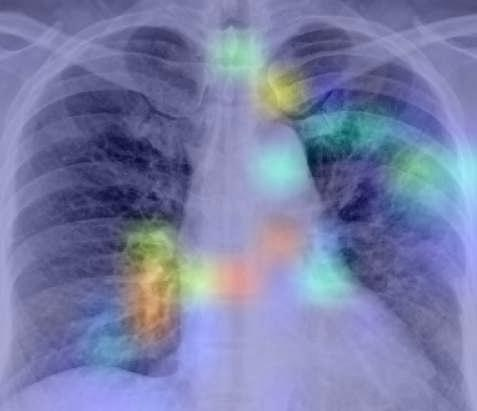

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "test_xray.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))